In [ ]:
from sklearn.model_selection import train_test_split
%reload_ext autoreload
%autoreload 2

import os
from glob import glob

import numpy as np
from tqdm import tqdm

## Convert from NIfTI format to Numpy Arrays

In [ ]:
"""
    Convert all .nii.gz files to .npy arrays
"""

from monai.transforms import CropForegroundd, EnsureChannelFirstD, LoadImaged, Orientationd, Compose, \
    RandCropByPosNegLabeld

NIB_EXT = ".nii.gz"
DATA_DIR = "data/ATLAS_2/Training"
OUTPUT_SCAN_DIR = "data/ATLAS_2/Processed/Scans"
OUTPUT_MASK_DIR = "data/ATLAS_2/Processed/Masks"

os.makedirs(OUTPUT_SCAN_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

scans_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*_T1w" + NIB_EXT), recursive=True))
masks_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*T1lesion_mask" + NIB_EXT), recursive=True))

assert len(masks_filepaths) == len(scans_filepaths), "Length of masks and scans does not match"

# add channel dimension as the first axis, keep MRI orientation, crop the brain bounding box to exclude non-informative pixels
# images will be reshaped to (1, 192, 192, 189) - (C, H, W, D)
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstD(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    RandCropByPosNegLabeld(keys=["image", "label"], num_samples=1, spatial_size=(192, 192, -1), pos=1, neg=1,
                           label_key="label"),
])

for scan_filepath, mask_filepath in tqdm(zip(scans_filepaths, masks_filepaths),
                                         total=len(scans_filepaths), desc=f"Converting from {NIB_EXT} to .npy"):
    results = transforms({"image": scan_filepath, "label": mask_filepath})

    scan, mask = results[0]["image"], results[0]["label"]

    output_scan_filepath = scan_filepath.split("/")[-1].split(".")[0] + ".npy"
    output_mask_filepath = mask_filepath.split("/")[-1].split(".")[0] + ".npy"

    np.save(os.path.join(OUTPUT_SCAN_DIR, output_scan_filepath), scan)  # noqa
    np.save(os.path.join(OUTPUT_MASK_DIR, output_mask_filepath), mask)  # noqa


# Filter healthy slices for Reconstruction

In [6]:
import os
from glob import glob
import numpy as np

from tqdm import tqdm

from utils import compute_head_mask
from constants import SCAN_DIM

import random


total_area = SCAN_DIM[-1] * SCAN_DIM[-2]
min_brain_area = 0.3

SCANS_DATA_DIR = "data/ATLAS_2/Processed/Scans"
MASKS_DATA_DIR = "data/ATLAS_2/Processed/Masks"

scans_filepaths = sorted(glob(os.path.join(SCANS_DATA_DIR, "*_T1w*.npy")))
masks_filepaths = sorted(glob(os.path.join(MASKS_DATA_DIR, "*T1lesion_mask*.npy")))

OUTPUT_SCAN2D_DIR = "data/ATLAS_2/Processed/2D/Scans2D"
OUTPUT_MASK2D_DIR = "data/ATLAS_2/Processed/2D/Masks2D"

os.makedirs(OUTPUT_SCAN2D_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK2D_DIR, exist_ok=True)

healthy, sick = 0, 0

for i in tqdm(range(len(scans_filepaths)), desc="Filtering scans for region proposal task"):
    scan = np.load(scans_filepaths[i])  # shape: (C, H, W, D)
    mask = np.load(masks_filepaths[i])  # shape: (C, H, W, D)

    healthy_slices = ~mask.any(axis=(0, 1, 2))
    sick_slices = ~healthy_slices
    sick += np.sum(sick_slices)

    sick_slices = np.argwhere(sick_slices).squeeze(-1)

    # head mask, shape: (C, H, W, kept_D)
    scan_head_mask = compute_head_mask(scan)  # should match same shape as scan
    # area per slice along D: sum over (C, H, W) -> (kept_D,)
    scan_head_mask_sum = np.sum(scan_head_mask, axis=(0, 1, 2))

    area_coverage = scan_head_mask_sum / total_area
    healthy_slices = healthy_slices & (area_coverage >= min_brain_area)
    healthy_slices = random.sample(list(healthy_slices), k=min(len(healthy_slices), len(sick_slices)))
    healthy_slices = np.asarray(healthy_slices)
    healthy += np.sum(healthy_slices)
    healthy_slices = np.argwhere(healthy_slices).squeeze(-1)

    slices = np.concatenate([healthy_slices, sick_slices])

    scan = scan[..., slices]
    mask = mask[..., slices]

    scan_filepath_basename = os.path.basename(scans_filepaths[i])
    masks_filepath_basename = os.path.basename(masks_filepaths[i])

    for j in range(scan.shape[-1]):
        output_scan2d_filepath = scan_filepath_basename.replace(".npy", f"_slice_{j}.npy")
        output_mask2d_filepath = masks_filepath_basename.replace(".npy", f"_slice_{j}.npy")
        np.save(os.path.join(OUTPUT_SCAN2D_DIR, output_scan2d_filepath), scan[..., j])
        np.save(os.path.join(OUTPUT_MASK2D_DIR, output_mask2d_filepath), mask[..., j])


Filtering scans for region proposal task: 100%|██████████| 655/655 [03:58<00:00,  2.74it/s]


In [7]:
sick, healthy

(np.int64(32987), np.int64(14902))

In [8]:
import os
from glob import glob
import re
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split

SEED = 42
SCANS_DIR = "data/ATLAS_2/Processed/2D/Scans2D"
MASKS_DIR = "data/ATLAS_2/Processed/2D/Masks2D"
OUTPUT_DIR = "data/ATLAS_2/Processed/2D/Splits/"

mask_paths = sorted(glob(os.path.join(MASKS_DIR, "*T1lesion_mask*.npy")))

def get_subject_id(fp):
    basename = os.path.basename(fp)
    prefix = basename.split("_")[0]  # expects 'sub-rXXXsXXX...' format
    return re.split(r"s\d+", prefix)[0]  # extracts 'sub-rXXX'

subjects = sorted({get_subject_id(fp) for fp in mask_paths})

train_subj, test_subj = train_test_split(subjects, test_size=0.2, random_state=SEED)
train_subj, val_subj = train_test_split(train_subj, test_size=0.1 / 0.8, random_state=SEED)

def filter_paths_by_subject(paths, subject_list):
    return [p for p in paths if get_subject_id(p) in subject_list]

train_masks = filter_paths_by_subject(mask_paths, train_subj)
val_masks   = filter_paths_by_subject(mask_paths, val_subj)
test_masks  = filter_paths_by_subject(mask_paths, test_subj)

splits = {
    "Train": train_masks,
    "Val":   val_masks,
    "Test":  test_masks,
}

for split_name, mask_list in splits.items():
    out_mask_dir = os.path.join(OUTPUT_DIR, split_name, "Masks")
    out_scan_dir = os.path.join(OUTPUT_DIR, split_name, "Scans")

    os.makedirs(out_mask_dir, exist_ok=True)
    os.makedirs(out_scan_dir, exist_ok=True)

    for mask_fp in tqdm(mask_list, desc=f"Creating {split_name} set"):
        scan_fp = mask_fp.replace("Masks2D", "Scans2D").replace("label-L_desc-T1lesion_mask", "T1w")

        shutil.move(mask_fp, os.path.join(out_mask_dir, os.path.basename(mask_fp)))
        shutil.move(scan_fp, os.path.join(out_scan_dir, os.path.basename(scan_fp)))

print("Train subjects:", len(train_subj))
print("Val subjects:  ", len(val_subj))
print("Test subjects: ", len(test_subj))
print("Train slices:  ", len(train_masks))
print("Val slices:    ", len(val_masks))
print("Test slices:   ", len(test_masks))


Creating Test set: 100%|██████████| 4621/4621 [00:02<00:00, 2006.22it/s]

Train subjects: 22
Val subjects:   4
Test subjects:  7
Train slices:   37092
Val slices:     6176
Test slices:    4621


## Dataset Split (Parameter tuning)

We split the dataset into a 80-10-10 manner. This split will be used for hyperparameter tuning

In [14]:
import os
from glob import glob

import pandas as pd

from utils import get_lesion_size_distribution, get_lesion_size_distribution_metadata, plot_lesion_size_distribution, round_half_up


DEPTH = 189
SEED = 42

SCANS_DATA_DIR = "data/ATLAS_2/Processed/Scans"
MASKS_DATA_DIR = "data/ATLAS_2/Processed/Masks"

scans_filepaths = sorted(glob(os.path.join(SCANS_DATA_DIR, "*_T1w*.npy")))
masks_filepaths = sorted(glob(os.path.join(MASKS_DATA_DIR, "*T1lesion_mask*.npy")))

sizes_distribution = get_lesion_size_distribution(scans_filepaths, masks_filepaths)
sizes_distribution = {size: sizes_distribution[size]["percentage"] for size in sizes_distribution.keys()}
sizes_distribution_metadata = get_lesion_size_distribution_metadata(scans_filepaths, masks_filepaths)

dataframe = [{"size": size, "filepath": fp[1]} for size in sizes_distribution.keys() for fp in sizes_distribution_metadata[size]["filepaths"]]
df = pd.DataFrame(dataframe)

# compute volume-level distribution
volume_dist = (
    df.groupby("filepath")["size"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# ensure 'filepath' is preserved
volume_dist.to_csv("volume_dist.csv")
volume_dist = pd.read_csv("volume_dist.csv")
os.remove("volume_dist.csv")

volume_dist = volume_dist.sample(frac=1, random_state=SEED)

total_slices = len(volume_dist) * DEPTH

assigned = set()
splits = {
    "train": {
        "percentage": 0.70,
        "indexes": [],
    },
    "val": {
        "percentage": 0.10,
        "indexes": [],
    },
    "test": {
        "percentage": 0.20,
        "indexes": [],
    }
}

for split in splits.keys():
    volumes_per_split = round_half_up(total_slices * splits[split]["percentage"])
    fold_target = {k: volumes_per_split * v // 100 for k, v in sizes_distribution.items()}

    for filepath, row in volume_dist.iterrows():
        if filepath in assigned:
            continue

        contrib = {k: row.get(k, 0) * DEPTH for k in sizes_distribution.keys()}
        if any(v > 0 for v in fold_target.values()):
            splits[split]["indexes"].append(filepath)
            assigned.add(filepath)
            for k in fold_target.keys():
                fold_target[k] = max(0, fold_target[k] - contrib[k])

train_masks_paths = list(volume_dist.loc[splits["train"]["indexes"]].filepath)
val_masks_paths = list(volume_dist.loc[splits["val"]["indexes"]].filepath)
test_masks_paths = list(volume_dist.loc[splits["test"]["indexes"]].filepath)

def make_paths(filepaths):
    masks = [fp for fp in filepaths]
    scans = [fp.replace(MASKS_DATA_DIR, SCANS_DATA_DIR).replace("label-L_desc-T1lesion_mask", "T1w") for fp in filepaths]

    return {"scans": scans, "masks": masks}

train_scans_paths = make_paths(train_masks_paths)["scans"]
val_scans_paths = make_paths(val_masks_paths)["scans"]
test_scans_paths = make_paths(test_masks_paths)["scans"]

Retrieving lesion size distribution data:   0%|          | 0/655 [00:00<?, ?it/s]/media/neurone-pc11/Volume/Angelo/strokeformer/utils/helpers.py:198: RuntimeWarning: invalid value encountered in divide
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
Retrieving lesion size distribution data: 100%|██████████| 655/655 [01:02<00:00, 10.50it/s]


Retrieving lesion size distribution data:   0%|          | 0/463 [00:00<?, ?it/s]/media/neurone-pc11/Volume/Angelo/strokeformer/utils/helpers.py:198: RuntimeWarning: invalid value encountered in divide
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
Retrieving lesion size distribution data: 100%|██████████| 463/463 [00:43<00:00, 10.54it/s]


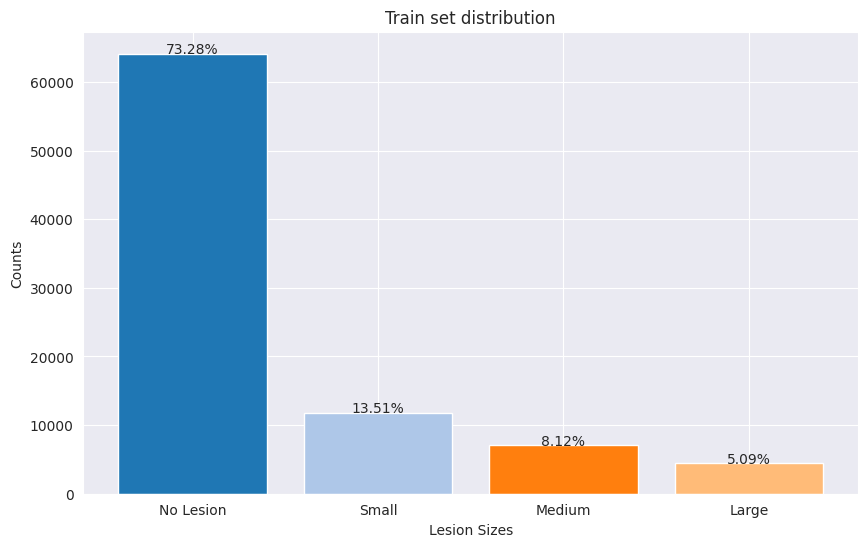

Retrieving lesion size distribution data: 100%|██████████| 82/82 [00:08<00:00, 10.09it/s]


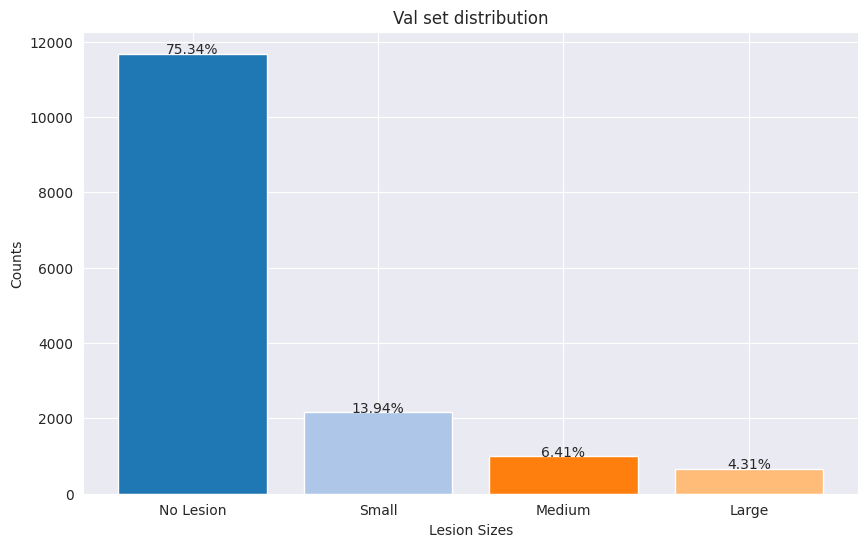

Retrieving lesion size distribution data: 100%|██████████| 110/110 [00:10<00:00, 10.25it/s]


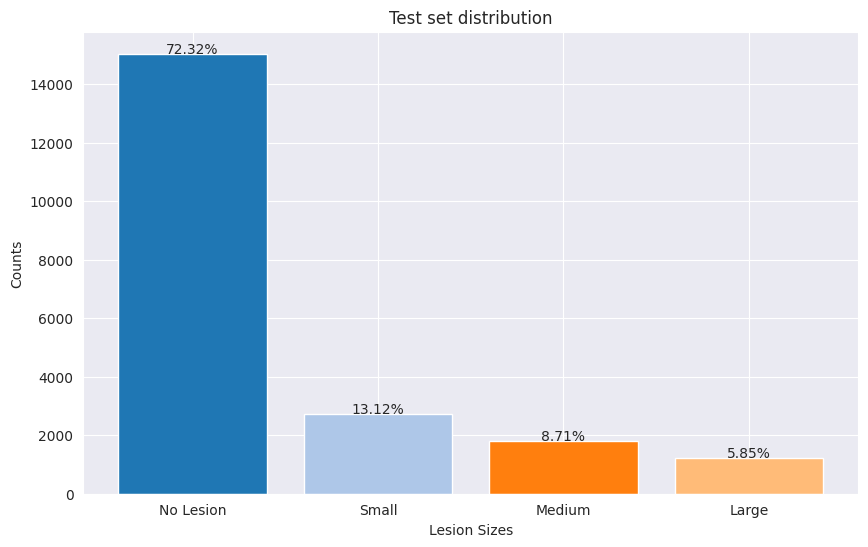

In [15]:
plot_lesion_size_distribution(train_scans_paths, train_masks_paths, title=f"Train set distribution")
plot_lesion_size_distribution(val_scans_paths, val_masks_paths, title=f"Val set distribution")
plot_lesion_size_distribution(test_scans_paths, test_masks_paths, title=f"Test set distribution")

In [16]:
import os
import shutil

from tqdm import tqdm

OUTPUT_DIR = "data/ATLAS_2/Processed/Splits/"
SPLITS = {
    "Train": train_masks_paths,
    "Val": val_masks_paths,
    "Test": test_masks_paths,
}

os.makedirs(OUTPUT_DIR, exist_ok=True)

for split, masks_filepaths in SPLITS.items():
    split_dir = os.path.join(OUTPUT_DIR, split)
    split_masks_dir = os.path.join(split_dir, "Masks")
    split_scans_dir = os.path.join(split_dir, "Scans")

    os.makedirs(split_masks_dir, exist_ok=True)
    os.makedirs(split_scans_dir, exist_ok=True)

    for mask_filepath in tqdm(masks_filepaths, desc=f"Creating {split} set"):
        scan_filepath = mask_filepath.replace("Masks", "Scans").replace("label-L_desc-T1lesion_mask", "T1w")

        shutil.copy(mask_filepath, os.path.join(split_masks_dir, mask_filepath.split(os.path.sep)[-1]))  # noqa
        shutil.copy(scan_filepath, os.path.join(split_scans_dir, scan_filepath.split(os.path.sep)[-1]))  # noqa

print(f"Train split: {len(train_masks_paths)}\nValidation split: {len(val_masks_paths)}\nTest split: {len(test_masks_paths)}")

Creating Test set: 100%|██████████| 110/110 [00:33<00:00,  3.31it/s]

Train split: 463
Validation split: 82
Test split: 110


## Augmentation: CarveMix + Ecological

In [ ]:
"""
    1. Find lesion and non-lesion slices that have closely head masks
    2. Refine the previous step to slices that have the most similar shape/size to lesion slices through IoU
    3. Calculate Structural Similarity Index (SSIM) to refine the previous step. Images with an high SSIM should have a similar vasculature structure
    4. Select the lesion and apply some morphological modification (e.g., contract, expand, rotate)
    5. Standardize intensities to smooth lesion integration
"""

In [1]:
import os
from glob import glob

SCANS_DIR = "data/ATLAS_2/Processed/Scans"
MASKS_DIR = "data/ATLAS_2/Processed/Masks"

# preload scans and masks as tensors for speeding up operations
scans_filepaths = sorted(glob(os.path.join(SCANS_DIR, "*.npy")))
masks_filepaths = sorted(glob(os.path.join(MASKS_DIR, "*.npy")))

In [2]:
import torch
import re

from torchmetrics.functional.image.ssim import structural_similarity_index_measure as ssim
from utils import compute_head_mask


def compare_head_sizes(sick_head_masks: torch.Tensor, healthy_head_masks: torch.Tensor,
                       threshold: float = 0.20) -> torch.Tensor:
    assert 0 <= threshold <= 1, "threshold must be between 0 and 1"

    if sick_head_masks.dtype != torch.bool:
        sick_head_masks = compute_head_mask(sick_head_masks)
    if healthy_head_masks.dtype != torch.bool:
        healthy_head_masks = compute_head_mask(healthy_head_masks)

    total_area = torch.tensor(sick_head_masks.shape[-3] * sick_head_masks.shape[-2],
                              device=sick_head_masks.device).float()

    # shape [N_sick]
    sick_head_masks_sum = sick_head_masks.float().sum(dim=(0, 1, 2))
    # shape [N_healthy]
    healthy_head_masks_sum = healthy_head_masks.float().sum(dim=(0, 1, 2))

    sick_head_masks_area = sick_head_masks_sum / total_area.repeat(sick_head_masks.shape[-1])
    healthy_head_masks_area = healthy_head_masks_sum / total_area.repeat(healthy_head_masks.shape[-1])

    # compute pairwise absolute differences (broadcasting)
    # sick_areas: [N_sick] → [N_sick, 1]
    # healthy_areas: [N_healthy] → [1, N_healthy]
    sick_head_masks_area = sick_head_masks_area.unsqueeze(-1)
    healthy_head_masks_area = healthy_head_masks_area.unsqueeze(0)
    abs_diff = (sick_head_masks_area - healthy_head_masks_area).abs()

    return abs_diff <= threshold


def compute_pairwise_iou(A, B):
    A = A.unsqueeze(-1)  # [..., N_sick] -> [..., N_sick, 1]
    B = B.unsqueeze(-2)  # [..., N_healthy] -> [..., 1, N_healthy]

    intersection = (A & B).sum(dim=(0, 1, 2))
    union = (A | B).sum(dim=(0, 1, 2))

    return intersection / (union + 1e-8)  # avoid division by zero


def compare_head_shapes(sick_head_mask: torch.Tensor, healthy_head_mask: torch.Tensor, threshold: float = 0.80) -> bool:
    assert 0 <= threshold <= 1, "threshold must be between 0 and 1"

    if sick_head_mask.dtype != torch.bool:
        sick_head_mask = compute_head_mask(sick_head_mask)
    if healthy_head_mask.dtype != torch.bool:
        healthy_head_mask = compute_head_mask(healthy_head_mask)

    iou_score = compute_pairwise_iou(sick_head_mask, healthy_head_mask)
    return iou_score >= threshold


def update_slice_positions(positions, remaining_slices):
    return {i: positions[r.item()] for i, r in enumerate(remaining_slices)}


def get_patient_id(filepath):
    basename = os.path.basename(filepath)
    prefix = basename.split("_")[0]  # expects 'sub-rXXXsXXX...' format
    return re.split(r"s\d+", prefix)[0]  # extracts 'sub-rXXX'

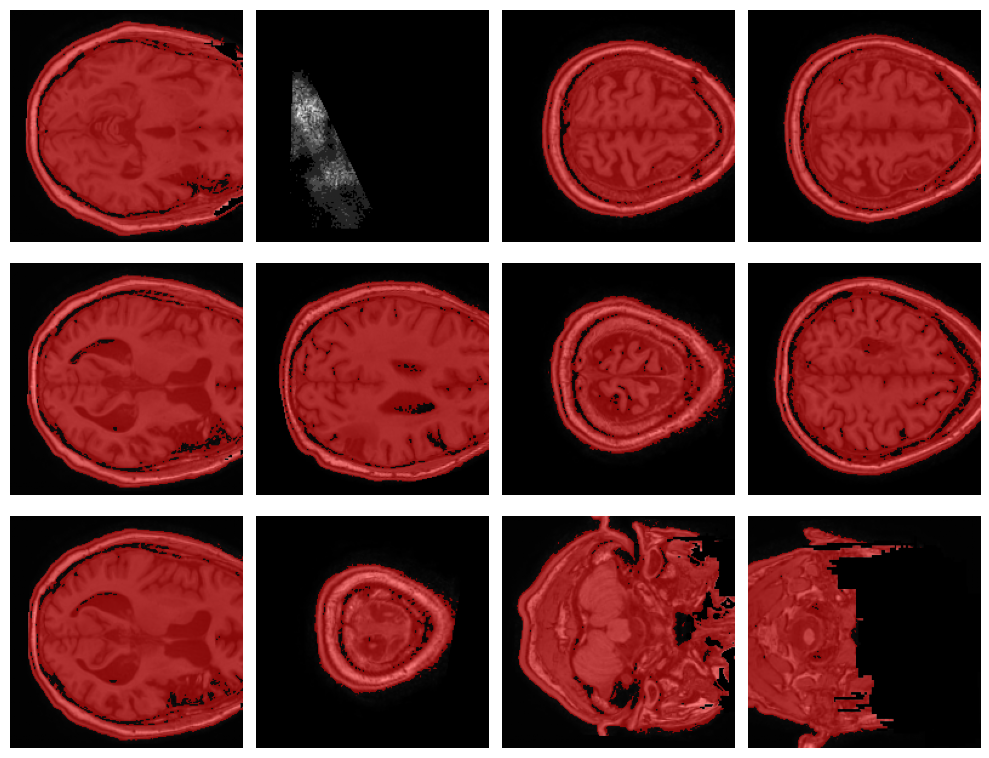

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))

for i in range(3):
    for j in range(4):
        slice_idx = random.randint(0, 188)
        scan = np.load(scans_filepaths[i * j])
        sick_slice = scan[0, ..., slice_idx]
        head_mask = compute_head_mask(torch.from_numpy(sick_slice))

        axes[i, j].imshow(sick_slice, cmap="gray")
        red_mask = np.zeros(head_mask.shape + (4,))  # rgba
        red_mask[head_mask, 0] = 1
        red_mask[head_mask, 3] = 0.5
        axes[i, j].imshow(red_mask)
        axes[i, j].axis("off")

fig.tight_layout(h_pad=0.15, w_pad=1)
plt.show()

In [3]:
import os
from collections import defaultdict

from tqdm import tqdm
import torch
import torch.nn.functional as F
import numpy as np

augmentation_plan = {}

ssim_threshold = 0.3
sizes_threshold = 0.3
shapes_threshold = 0.7
sigma = 1.5
kernel_size = int(3.5 * sigma + 0.5) * 2 + 1
min_depth = kernel_size // 2 + 1

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

for healthy_scan_filepath in tqdm(scans_filepaths, desc="Finding most similar sick-healthy pairs"):
    healthy_patient_id = get_patient_id(healthy_scan_filepath)
    healthy_mask_filepath = healthy_scan_filepath.replace("Scans", "Masks").replace("_T1w",
                                                                                    "_label-L_desc-T1lesion_mask")

    mask = torch.from_numpy(np.load(healthy_mask_filepath)).to(device=device)

    healthy_mask = ~mask.any(dim=(0, 1, 2))  # shape (D,)
    healthy_slices_indices = torch.argwhere(healthy_mask).flatten()

    if len(healthy_slices_indices) == 0:
        continue

    healthy_global_indices_map = {i: index.item() for i, index in enumerate(healthy_slices_indices)}

    scan = torch.from_numpy(np.load(healthy_scan_filepath)).to(device=device)
    healthy_scan = scan[..., healthy_slices_indices]

    augmentation_plan[healthy_scan_filepath] = defaultdict(list)

    for sick_scan_filepath in scans_filepaths:
        sick_patient_id = get_patient_id(sick_scan_filepath)

        if healthy_patient_id == sick_patient_id:
            continue

        sick_mask_filepath = sick_scan_filepath.replace("Scans", "Masks").replace("_T1w", "_label-L_desc-T1lesion_mask")
        mask = torch.from_numpy(np.load(sick_mask_filepath)).to(device=device)
        sick_mask = mask.any(dim=(0, 1, 2))
        
        sick_slices_indices = torch.argwhere(sick_mask).flatten()

        if len(sick_slices_indices) == 0:
            continue

        sick_global_indices_map = {i: index.item() for i, index in enumerate(sick_slices_indices)}
        scan = torch.from_numpy(np.load(sick_scan_filepath)).to(device=device)
        sick_scan = scan[..., sick_slices_indices]

        # step 1: Size mask comparison - boolean mask of shape [N_sick, N_healthy]
        sizes_scores = compare_head_sizes(healthy_scan, sick_scan, threshold=sizes_threshold)

        if not sizes_scores.any():
            continue

        true_pairs = torch.nonzero(sizes_scores, as_tuple=False)

        healthy_slices = true_pairs[:, 0].unique()
        sick_slices = true_pairs[:, 1].unique()

        sick_global_indices_map = update_slice_positions(sick_global_indices_map, sick_slices)
        healthy_global_indices_map = update_slice_positions(healthy_global_indices_map, healthy_slices)

        healthy_scan = healthy_scan[..., healthy_slices]
        sick_scan = sick_scan[..., sick_slices]

        # step 2: Shape mask comparison (same slicing)
        shapes_scores = compare_head_shapes(healthy_scan, sick_scan, threshold=shapes_threshold)

        if not shapes_scores.any():
            continue

        true_pairs = torch.nonzero(shapes_scores, as_tuple=False)

        healthy_slices = true_pairs[:, 0].unique()
        sick_slices = true_pairs[:, 1].unique()

        sick_global_indices_map = update_slice_positions(sick_global_indices_map, sick_slices)
        healthy_global_indices_map = update_slice_positions(healthy_global_indices_map, healthy_slices)

        healthy_scan = healthy_scan[..., healthy_slices]
        sick_scan = sick_scan[..., sick_slices]

        n_sick_slices = sick_scan.shape[-1]

        if n_sick_slices < min_depth:
            pad_amount = min_depth - n_sick_slices
            pad_dims = (0, pad_amount) + (0, 0) * (sick_scan.dim() - 1)
            sick_scan = F.pad(sick_scan, pad_dims, mode="constant", value=0)

        window_size = sick_scan.shape[-1]
        total_healthy = healthy_scan.shape[-1]

        # sliding window over sick slices with stride smaller or equal to window size
        stride = window_size

        for start in range(0, total_healthy, stride):
            end = min(start + window_size, total_healthy)
            healthy_window = healthy_scan[..., start:end]

            if healthy_window.shape[-1] < window_size:
                pad_amount = window_size - healthy_window.shape[-1]

                pad_dims = (0, pad_amount) + (0, 0) * (healthy_window.dim() - 1)
                healthy_window = F.pad(healthy_window, pad_dims, "constant", 0)

            # input shape must be either BxCxHxW or BxCxHxWxD
            # current input shape is CxHxWxD
            # SSIM map: result shape should be [B, C, H, W, window_size]
            _, full_ssim_map = ssim(sick_scan.unsqueeze(0), healthy_window.unsqueeze(0), return_full_image=True, sigma=sigma)

            # remove padded positions from SSIM map
            if healthy_window.shape[-1] > end - start:
                full_ssim_map = full_ssim_map[..., :end - start]

                if n_sick_slices < window_size:
                    full_ssim_map = full_ssim_map[..., :n_sick_slices]

            # average SSIM over dims (B, C, H, W)
            ssim_scores = full_ssim_map.mean(dim=(0, 1, 2, 3))

            valid_pairs_mask = ssim_scores >= ssim_threshold
            valid_indices = torch.nonzero(valid_pairs_mask, as_tuple=False).flatten()

            # record the matched pair mapping back to original indices
            for i in valid_indices:
                sick_global_idx = sick_global_indices_map.get(i.item(), None)
                if sick_global_idx is None:
                    sick_global_idx = sick_global_indices_map[list(sick_global_indices_map.keys())[-1]]
                healthy_global_idx = healthy_global_indices_map.get(start + i.item(), None)
                if healthy_global_idx is None:
                    healthy_global_idx = healthy_global_indices_map[list(healthy_global_indices_map.keys())[-1]]

                augmentation_plan[healthy_scan_filepath][healthy_global_idx].append({
                    "sick_scan": sick_scan_filepath,
                    "sick_slice_idx": sick_global_idx,
                })
        del sick_scan
        torch.cuda.empty_cache()

    if len(augmentation_plan[healthy_scan_filepath]) == 0:
        del augmentation_plan[healthy_scan_filepath]

    del healthy_scan
    torch.cuda.empty_cache()

Finding most similar sick-healthy pairs: 100%|██████████| 655/655 [9:39:06<00:00, 53.05s/it]    


In [4]:
from itertools import chain
from typing import Tuple, Optional

import torch
import torch.nn.functional as F
from torch import Tensor


# overwriting pietorch functions as in pietorch 0.0.1, the green function is left on cpu when computed internally
# await PR merge to fix the issue

stability_value = 1e-8
INTEGRATION_MODES = ['origin']
PAD_AMOUNT = 4


def construct_dirac_laplacian(lib, shape: Tuple[int], channels_dim: int = None, requires_pad: bool = True, device=None):
    num_dims = len(shape)
    chosen_dimensions = [d for d in range(num_dims) if d != channels_dim]
    # Aim is to match chosen dimensions of input shape (padding if necessary), but set others to size 1.
    padding = 2 * PAD_AMOUNT if requires_pad else 0
    shape = [(s + padding) if i in chosen_dimensions else 1 for i, s in enumerate(shape)]
    kernel_centre = [1 if d in chosen_dimensions else 0 for d in range(num_dims)]

    dirac_kernel = lib.zeros(shape, device=device)
    dirac_kernel[tuple(kernel_centre)] = 1

    laplace_kernel = lib.zeros(shape, device=device)
    laplace_kernel[tuple(kernel_centre)] = 2 * len(chosen_dimensions)
    for c_d in chosen_dimensions:
        for i in [0, 2]:
            laplace_kernel[tuple([i if d == c_d else k for d, k in enumerate(kernel_centre)])] = -1

    return dirac_kernel, laplace_kernel


def blend(target: Tensor, source: Tensor, mask: Tensor, corner_coord: Tensor, mix_gradients: bool,
          channels_dim: Optional[int] = None, green_function: Optional[Tensor] = None,
          integration_mode: str = 'origin') -> Tensor:
    """Use Poisson blending to integrate the source image into the target image at the specified location.

    :param target: The image to be blended into.
    :param source: The image to be blended. Must have the same number of dimensions as target.
    :param mask: A mask indicating which regions of the source should be blended (allowing for non-rectangular shapes).
        Must be equal in dimensions to source, excluding the channels dimension if present.
    :param corner_coord: The location in the target for the lower corner of the source to be blended. Is a spatial
        coordinate, so does not include channels dimension.
    :param mix_gradients: Whether the stronger gradient of the two images is used in the blended region. If false, the
        source gradient is always used. `True` behaves similar to the MIXED_CLONE flag for OpenCV's seamlessClone, while
        `False` acts like NORMAL_CLONE.
    :param channels_dim: Optional, indicates a channels dimension, which should not be blended over.
    :param green_function: Optional, precomputed Green function to be used.
    :param integration_mode: Method of computing the integration constant. Probably should not be touched.
    :return: The result of blending the source into the target.
    """
    # If green_function is provided, it should match the padded image size
    num_dims = len(target.shape)
    if channels_dim is not None:
        channels_dim %= num_dims
    assert integration_mode in INTEGRATION_MODES, f'Invalid integration mode {integration_mode}, should be one of ' \
                                                  f'{INTEGRATION_MODES}'

    device_check_dict = {'source': source.device, 'mask': mask.device, 'green_function':
        green_function.device if green_function else None}

    target_device = target.device
    for tensor, device in device_check_dict.items():
        if tensor == 'green_function' and device is None:
            continue
        if device != target_device:
            raise ValueError(f"target and {tensor} expected to be on the same device, found {target_device} and {device}!")

    # Determine dimensions to operate on
    chosen_dimensions = [d for d in range(num_dims) if d != channels_dim]
    corner_dict = dict(zip(chosen_dimensions, corner_coord.numpy()))

    result = target.clone()
    target = target[tuple([slice(corner_dict[i], corner_dict[i] + s_s) if i in chosen_dimensions else slice(None)
                           for i, s_s in enumerate(source.shape)])]

    # Zero edges of mask, to avoid artefacts
    for d in range(len(mask.shape)):
        mask[tuple([[0, -1] if i == d else slice(None) for i in range(len(mask.shape))])] = 0

    # Pad images in operating dimensions
    pad_amounts = [PAD_AMOUNT if d in chosen_dimensions else 0 for d in range(num_dims)]
    pad = tuple(chain(*[[p, p] for p in reversed(pad_amounts)]))

    target_pad = F.pad(target, pad)
    source_pad = F.pad(source, pad)

    # Pad with zeroes, as don't blend within padded region
    if channels_dim is not None:
        del pad_amounts[channels_dim]
        pad = tuple(chain(*[[p, p] for p in reversed(pad_amounts)]))
    mask_pad = F.pad(mask, pad)

    # Compute gradients
    target_grads = torch.gradient(target_pad, dim=chosen_dimensions)
    source_grads = torch.gradient(source_pad, dim=chosen_dimensions)

    # Blend gradients, MIXING IS DONE AT INDIVIDUAL DIMENSION LEVEL!
    if mix_gradients:
        source_grads = [torch.where(torch.ge(torch.abs(t_g), torch.abs(s_g)), t_g, s_g)
                        for t_g, s_g in zip(target_grads, source_grads)]

    if channels_dim is not None:
        mask_pad = mask_pad.unsqueeze(channels_dim)

    blended_grads = [t_g * (1 - mask_pad) + s_g * mask_pad for t_g, s_g in zip(target_grads, source_grads)]

    # Compute laplacian
    laplacian = torch.sum(torch.stack([torch.gradient(grad, dim=grad_dim)[0]
                                       for grad, grad_dim in zip(blended_grads, chosen_dimensions)]),
                          dim=0)

    # Compute green function if not provided
    if green_function is None:
        green_function = construct_green_function(laplacian.shape, channels_dim, requires_pad=False, device=target_device)
    else:
        for d in range(num_dims):
            if d in chosen_dimensions:
                assert green_function.shape[d] == laplacian.shape[d], f'Green function has mismatched shape on ' \
                                                                      f'dimension {d}: expected {laplacian.shape[d]},' \
                                                                      f' got {green_function.shape[d]}.'
            else:
                assert green_function.shape[d] == 1, f'Green function should have size 1 in non-chosen dimension ' \
                                                     f'{d}: has {green_function.shape[d]}.'

    # Apply green function convolution
    init_blended = torch.fft.ifftn(torch.fft.fftn(laplacian, dim=chosen_dimensions) * green_function,
                                   dim=chosen_dimensions)

    # Use boundaries to determine integration constant, and extract inner blended image
    if integration_mode == 'origin':
        integration_constant = init_blended[tuple([slice(1) if i in chosen_dimensions else slice(None)
                                                   for i in range(num_dims)])]
    else:
        assert False, 'Invalid integration constant, how did you get here?'

    # Leave out padding + border, to avoid artefacts
    inner_blended = init_blended[tuple([slice(PAD_AMOUNT + 1, -PAD_AMOUNT - 1) if i in chosen_dimensions else slice(None)
                                        for i in range(num_dims)])]

    res_indices = tuple([slice(corner_dict[i] + 1, corner_dict[i] + s_s - 1) if i in chosen_dimensions else slice(None)
                         for i, s_s in enumerate(source.shape)])
    result[res_indices] = torch.real(inner_blended - integration_constant)
    return result


def construct_green_function(shape: Tuple[int], channels_dim: int = None, requires_pad: bool = True, device: Optional[torch.device] = None) -> Tensor:
    """Construct Green function to be used in convolution within Fourier space.

    :param shape: Target shape of Green function.
    :param channels_dim: Optional, indicates if shape includes a channels dimension, which should not be convolved over.
    :param requires_pad: Indicates whether padding must be applied to `shape` prior to Green function construction.
    :param device: Optional, indicates the device onto which construct the tensor.
    :return: Green function in the Fourier domain.
    """
    num_dims = len(shape)
    chosen_dimensions = [d for d in range(num_dims) if d != channels_dim]

    dirac_kernel, laplace_kernel = construct_dirac_laplacian(torch, shape, channels_dim, requires_pad, device)

    dirac_kernel_fft = torch.fft.fftn(dirac_kernel, dim=chosen_dimensions)
    laplace_kernel_fft = torch.fft.fftn(laplace_kernel, dim=chosen_dimensions)
    return -dirac_kernel_fft / (laplace_kernel_fft + stability_value)


def blend_wide(target: Tensor, source: Tensor, mask: Tensor, corner_coord: Tensor, mix_gradients: bool,
               channels_dim: Optional[int] = None, green_function: Optional[Tensor] = None,
               integration_mode: str = 'origin') -> Tensor:
    # Zero edges of mask, to avoid artefacts
    for d in range(len(mask.shape)):
        mask[tuple([[0, -1] if i == d else slice(None) for i in range(len(mask.shape))])] = 0

    num_dims = len(target.shape)
    if channels_dim is not None:
        channels_dim %= num_dims
    chosen_dimensions = [d for d in range(num_dims) if d != channels_dim]
    corner_dict = dict(zip(chosen_dimensions, corner_coord.numpy()))

    indices_to_blend = [slice(corner_dict[i], corner_dict[i] + s_s) if i in chosen_dimensions else slice(None)
                        for i, s_s in enumerate(source.shape)]

    new_source = torch.zeros_like(target)
    new_source[tuple(indices_to_blend)] = source

    new_mask = torch.zeros([target.shape[d] for d in chosen_dimensions])
    if channels_dim is not None:
        del indices_to_blend[channels_dim]
    new_mask[tuple(indices_to_blend)] = mask

    return blend(target, new_source, new_mask, torch.tensor([0] * len(chosen_dimensions)), mix_gradients, channels_dim,
                 green_function, integration_mode)

In [5]:
import json
import random
import cv2

from scipy.ndimage import rotate

from utils import get_lesion_size


# structure is:
# - healthy_scan:
#   - healthy_slice_idx:
#       - list of dicts containing which scans and which sick slices are most similar to the current healthy_slice


def rotate_slice(s: torch.Tensor, angle: float, 
                 axes: tuple[int, int] = (1, 2), 
                 order: int = 3, cval: float = 0.0, 
                 dtype: torch.dtype = None) -> torch.Tensor:
    s_numpy = rotate(s.cpu().numpy(), angle, axes=axes, order=order, cval=cval)
    s = torch.from_numpy(s_numpy).to(device=device)
    
    if dtype is not None:
        s = s.to(dtype=dtype)
    
    return s


JSON_FILE = 'augmented_scans.json'
MASKS_OUT_DIR = "data/ATLAS_2/Processed/Augmented/Masks"
SCANS_OUT_DIR = "data/ATLAS_2/Processed/Augmented/Scans"

os.makedirs(MASKS_OUT_DIR, exist_ok=True)
os.makedirs(SCANS_OUT_DIR, exist_ok=True)

records = []  # list of dicts, one per augmented scan

corner_coord = torch.tensor([0, 0])  # start at 0,0 since all images have the same dim
bounding_box_threshold = 0.20
slice_delta = 30 # needed as a safety mechanism to ensure lesions are taken from slices that show the same anatomy
rotation_angles = (-30, 30)
morph_kernel = np.ones((5, 5))

# for each healthy_slice, collect all sick slices, combine their lesions (CarveMix??), blend it into the healthy slice,
# repeat for all healthy slice of the current scan
# save the augmented volume
slice_mask = torch.zeros((1, 192, 192)).to(device=device)

for healthy_scan in tqdm(augmentation_plan.keys(), desc="Augmenting healthy slices"):
    augmented_scan = torch.from_numpy(np.load(healthy_scan)).to(device=device)
    augmented_mask = torch.from_numpy(
        np.load(healthy_scan.replace("Scans", "Masks").replace("_T1w", "_label-L_desc-T1lesion_mask"))).to(
        device=device, dtype=torch.uint8)
    augmented_scan_name = os.path.basename(healthy_scan).replace("T1w", "T1w_augmented")
    augmented_mask_name = os.path.basename(healthy_scan).replace("_T1w", "_label-L_desc-T1lesion_mask_augmented")
    record = {
        "augmented_scan": augmented_scan_name,
        "augmented_mask": augmented_mask_name,
        "healthy_scan": os.path.basename(healthy_scan),
        "healthy_slices": {}
    }
    for healthy_slice_idx, matched_sick_slices in augmentation_plan[healthy_scan].items():
        sick_slices = []
        sick_masks = []
        healthy_slice = augmented_scan[..., healthy_slice_idx]
        record["healthy_slices"][str(healthy_slice_idx)] = []

        for matched_sick_slice in matched_sick_slices:
            if abs(matched_sick_slice['sick_slice_idx'] - healthy_slice_idx) > slice_delta:
                continue
            sick_scan_path = matched_sick_slice['sick_scan']
            sick_scan = torch.from_numpy(np.load(sick_scan_path)).to(device=device)
            sick_mask = torch.from_numpy(np.load(
                sick_scan_path.replace("Scans", "Masks").replace("_T1w", "_label-L_desc-T1lesion_mask")
            )).to(device=device, dtype=torch.uint8)

            sick_slices.append(sick_scan[..., matched_sick_slice['sick_slice_idx']])
            sick_masks.append(sick_mask[..., matched_sick_slice['sick_slice_idx']])

            record["healthy_slices"][str(healthy_slice_idx)].append({
                "sick_scan": os.path.basename(sick_scan_path),
                "sick_slice_idx": matched_sick_slice["sick_slice_idx"]
            })

        if len(sick_slices) == 0:
            del record["healthy_slices"][str(healthy_slice_idx)]
            continue
        
        healthy_mask = slice_mask.clone()
        healthy_copy = healthy_slice.clone()
        healthy_min, healthy_max = healthy_slice.min(), healthy_slice.max()
        chosen_rotation_angles = []
        
        for i in range(len(sick_masks)):
            sick_slice = sick_slices[i]
            sick_mask = sick_masks[i]
                                                            
            rot_prob = random.random()
            
            new_mask = torch.zeros_like(sick_mask, device=sick_mask.device)
            
            if rot_prob >= 0.5:
                # rotate whole scans and masks to avoid artifacts
                rotation_angle = random.uniform(*rotation_angles)
                chosen_rotation_angles.append(rotation_angle)
                
                sick_mask = rotate_slice(sick_mask, rotation_angle, order=0, dtype=torch.uint8)
                sick_slice = rotate_slice(sick_slice, rotation_angle)
                healthy_copy = rotate_slice(healthy_slice, rotation_angle)
            
            _, thresh = cv2.threshold(sick_mask[0].to(dtype=torch.uint8).cpu().numpy(), 0, 1, cv2.THRESH_BINARY)
            num_lesions, labeled_mask, stats, _ = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S)

            # choose random lesions from mask
            lesion_ids = list(np.unique(labeled_mask)[1:])
            if len(lesion_ids) == 0:
                continue
            lesion_ids = random.sample(lesion_ids, k=random.randint(1, len(lesion_ids)))

            # new mask containing only the lesions sampled above
            labeled_mask = torch.from_numpy(labeled_mask).to(device=device)

            for lesion_id in lesion_ids:
                selected_lesion_mask = sick_mask * (labeled_mask == lesion_id)
                # get lesion bounding box and do local blending to avoid too much blurring on the whole scan
                x_min = stats[lesion_id, cv2.CC_STAT_LEFT]
                y_min = stats[lesion_id, cv2.CC_STAT_TOP]
                x_max = x_min + stats[lesion_id, cv2.CC_STAT_WIDTH]
                y_max = y_min + stats[lesion_id, cv2.CC_STAT_HEIGHT]
                
                healthy_portion = healthy_copy[:, y_min:y_max, x_min:x_max].clone()
                sick_portion = sick_slice[:, y_min:y_max, x_min:x_max]
                mask_portion = selected_lesion_mask[0, y_min:y_max, x_min:x_max]
                
                if random.random() >= 0.5 and get_lesion_size(sick_slice, selected_lesion_mask) == "Large":
                    mask_portion = mask_portion.cpu().numpy()
                    mask_portion = cv2.erode(mask_portion, morph_kernel, iterations=1)
                    mask_portion = torch.from_numpy(mask_portion).to(device=device, dtype=torch.uint8)
                
                healthy_portion = blend(healthy_portion, sick_portion, mask_portion, corner_coord, True, channels_dim=0)
                healthy_copy[:, y_min:y_max, x_min:x_max] = healthy_portion.clone()
                
                if rot_prob >= 0.5:
                    # rotate back to restore original orientation and shape, only first lesion will be rotated
                    # this is fine as most healthy slices are paired with one sick slice containing one lesion
                    selected_lesion_mask = rotate_slice(selected_lesion_mask, -chosen_rotation_angles[-1], order=0, dtype=torch.uint8)
                    
                    original_size = healthy_slice.shape # (C, H, W)
                    rotated_img_shape = selected_lesion_mask.shape
                    center_x, center_y = rotated_img_shape[2] // 2, rotated_img_shape[1] // 2
                    
                    start_x = center_x - original_size[2] // 2
                    start_y = center_y - original_size[1] // 2

                    selected_lesion_mask = selected_lesion_mask[:, start_y:start_y + original_size[1], start_x:start_x + original_size[2]]
                    selected_lesion_mask = torch.clamp(selected_lesion_mask, 0, 1)
                
                new_mask += selected_lesion_mask
                new_mask = torch.clamp(new_mask, 0, 1)
            
            healthy_mask += new_mask
            healthy_mask = torch.clamp(healthy_mask, 0, 1)  # keep range in 0-1 in case of overlap
        
        if len(chosen_rotation_angles) > 0:
            # rotate back to restore original orientation and shape, only first lesion will be rotated
            # this is fine as most healthy slices are paired with one sick slice containing one lesion
            for angle in chosen_rotation_angles[::-1]:
                healthy_copy = rotate_slice(healthy_copy, -angle)
            
            original_size = healthy_slice.shape # (C, H, W)
            rotated_img_shape = healthy_copy.shape
            center_x, center_y = rotated_img_shape[2] // 2, rotated_img_shape[1] // 2
            
            start_x = center_x - original_size[2] // 2
            start_y = center_y - original_size[1] // 2

            healthy_copy = healthy_copy[:, start_y:start_y + original_size[1], start_x:start_x + original_size[2]]
            healthy_copy = torch.clamp(healthy_copy, healthy_min, healthy_max)
            
        augmented_scan[..., healthy_slice_idx] = healthy_copy
        augmented_mask[..., healthy_slice_idx] = healthy_mask

    if len(record['healthy_slices']) > 0:
        records.append(record)

        # save augmented scan and mask
        np.save(os.path.join(SCANS_OUT_DIR, augmented_scan_name), augmented_scan.cpu())  # noqa
        np.save(os.path.join(MASKS_OUT_DIR, augmented_mask_name), augmented_mask.cpu())  # noqa

if len(records) > 0:
    with open(JSON_FILE, 'w') as f:
        json.dump(records, f, indent=2)

Augmenting healthy slices:   0%|          | 2/655 [08:48<47:57:11, 264.37s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.90 GiB. GPU 0 has a total capacity of 23.49 GiB of which 9.13 GiB is free. Process 1770 has 12.03 MiB memory in use. Including non-PyTorch memory, this process has 11.09 GiB memory in use. Process 71211 has 1.83 GiB memory in use. Of the allocated memory 10.43 GiB is allocated by PyTorch, and 204.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

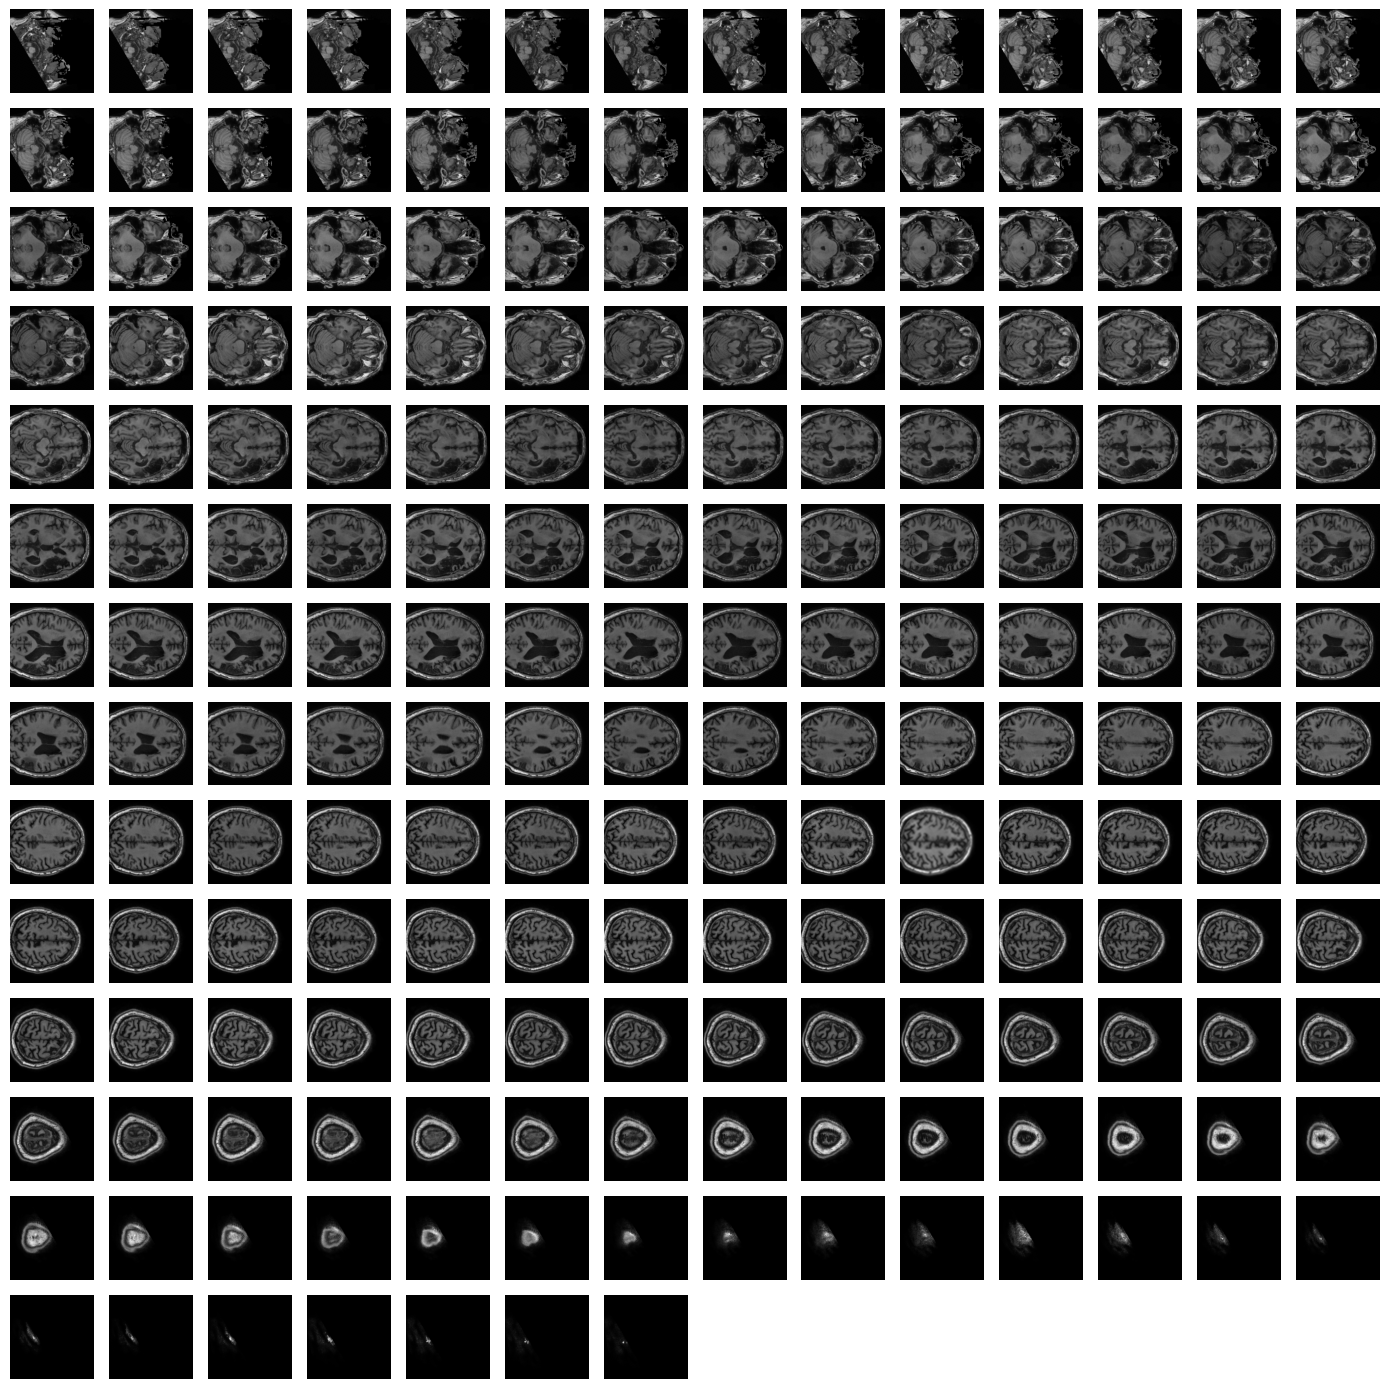

In [35]:
from utils import plot_mri_slices

x = np.load("data/ATLAS_2/Processed/Augmented/Scans/sub-r001s002_ses-1_space-MNI152NLin2009aSym_T1w_augmented.npy")

plot_mri_slices(x)

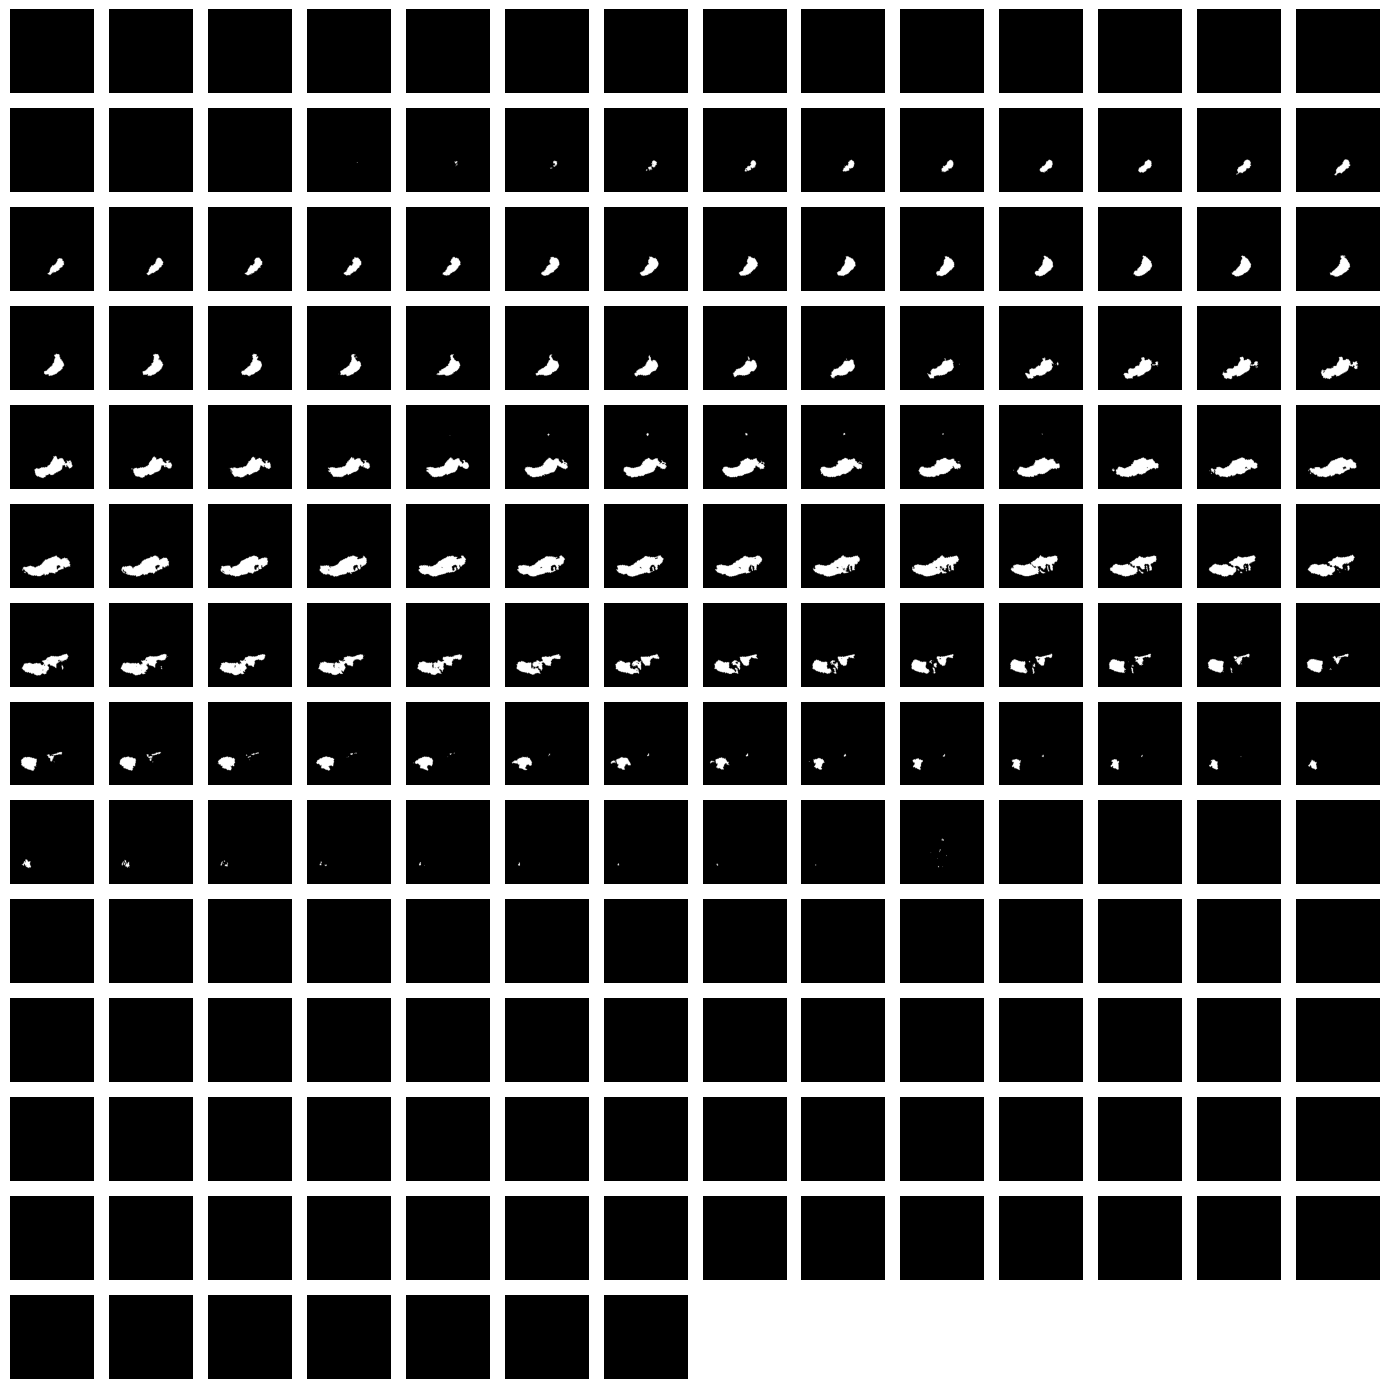

In [36]:
y = np.load("data/ATLAS_2/Processed/Augmented/Masks/sub-r001s002_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask_augmented.npy")

plot_mri_slices(y)

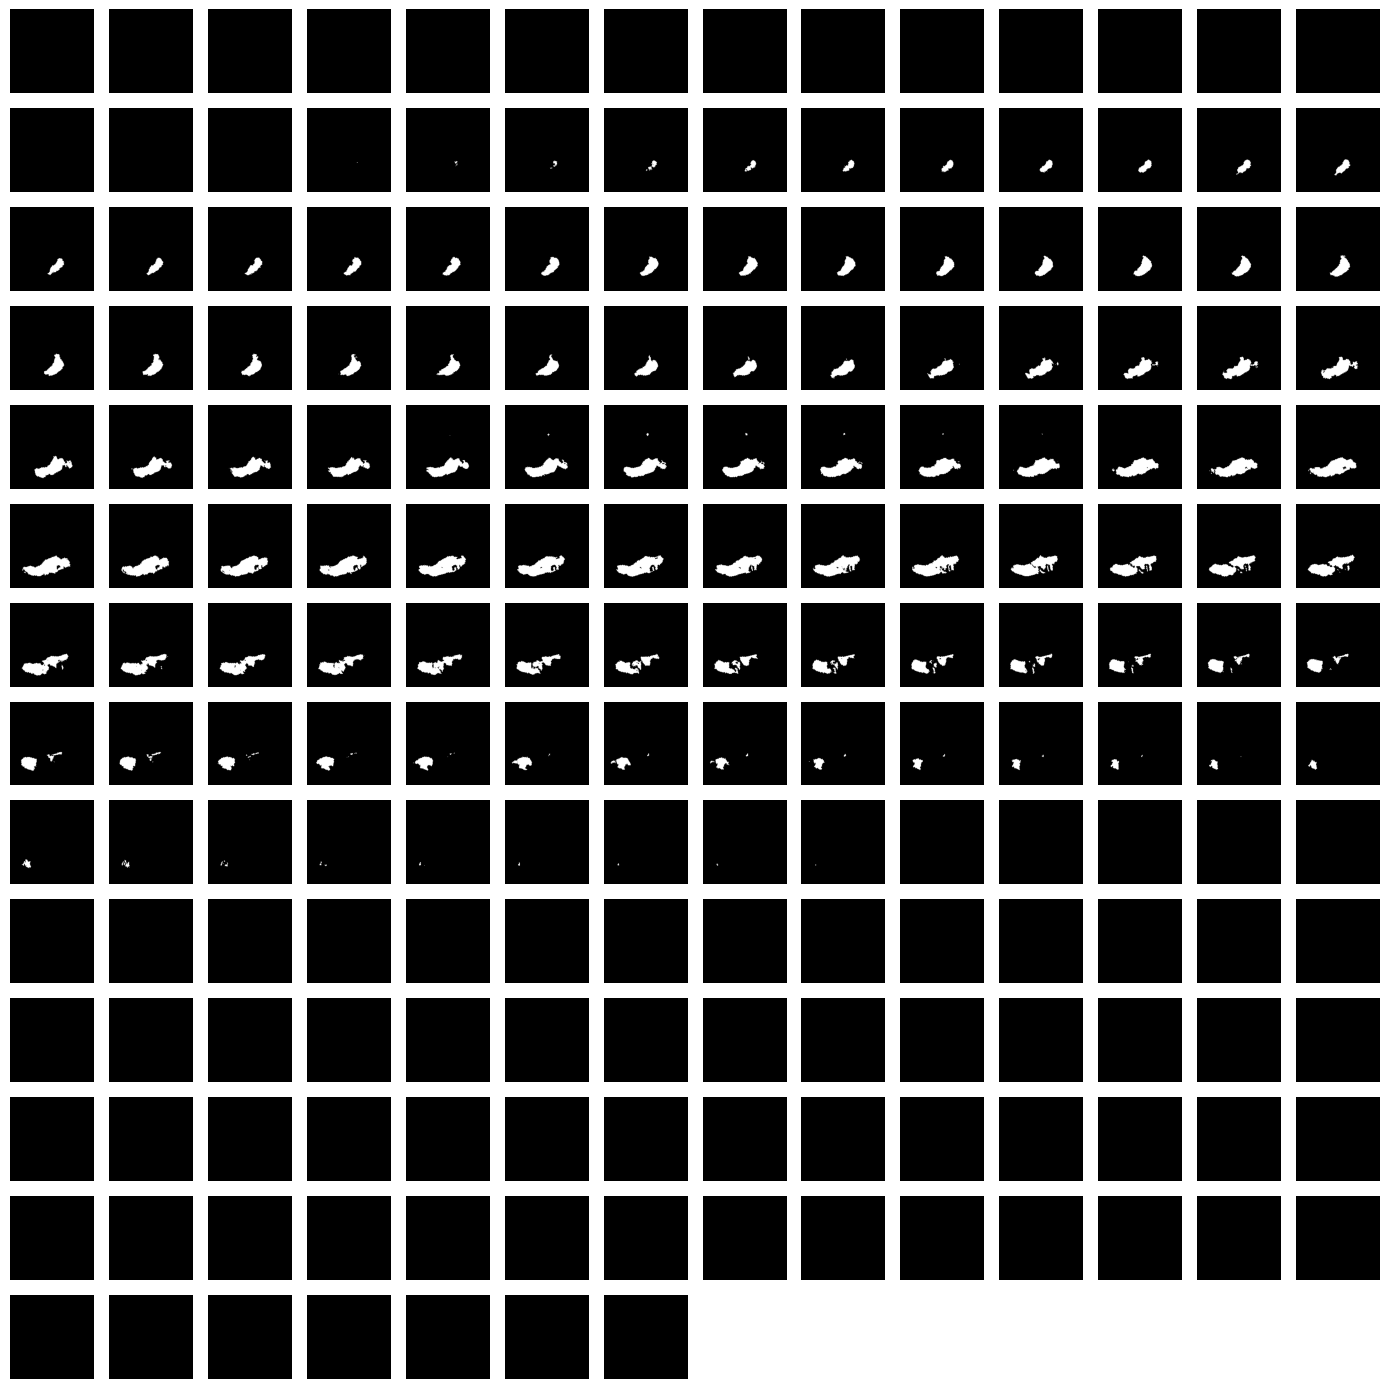

In [37]:
z = np.load("data/ATLAS_2/Processed/Masks/sub-r001s002_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.npy")
plot_mri_slices(z)

In [ ]:
z = np.load("data/ATLAS_2/Processed/Masks/sub-r001s002_ses-1_space-MNI152NLin2009aSym_label-L_desc-T1lesion_mask.npy")

plot_mri_slices(z)